In [1]:
import argparse
import numpy as np
import os
from math import log10, floor
from datetime import datetime
from glob import glob
import stat
import pickle
import math
import array
import scipy
from multiprocessing import Pool
from itertools import repeat
from pathlib import Path
from scipy.signal import correlate
from scipy.fft import ifft, fft, next_fast_len
import qetpy as qp
import matplotlib
import matplotlib.pyplot as plt
import pytesdaq.io.hdf5 as h5io
import pytesdaq
from detprocess.core import OptimumFilterTrigger, EventBuilder, Template, Noise, Salting
from detprocess import FilterData
from pprint import pprint
from scipy import stats, signal, interpolate, special, integrate
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import types
import mendeleev
import pickle as pkl
import sys
import cloudpickle
from darklim import constants

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


In [2]:
def helmfactor(er, tm='Si'):
    """
    The analytic nuclear form factor via the Helm approximation.

    Parameters
    ----------
    er : array_like
        The recoil energy to use in the form factor calculation, units of keV.
    tm : str, int, optional
        The target material of the detector. Can be passed as either the atomic symbol, the
        atomic number, or the full name of the element. Default is 'Si'.

    Returns
    -------
    ffactor2 : ndarray
        The square of the dimensionless form factor for the inputted recoil energies and target
        material.

    Notes
    -----
    This form factor uses Helm's approximation to the charge density of the nucleus, as explained by
    Lewin and Smith in section 4 of their paper:
        - https://doi.org/10.1016/S0927-6505(96)00047-3

    """

    er = np.atleast_1d(er)

    hbarc = constants.hbar * constants.c / constants.e * 1e-6 * 1e15 # [MeV fm]
    mn = constants.atomic_mass * constants.c**2 / constants.e * 1e-9 # 1 amu in [GeV]
    atomic_weight = mendeleev.element(tm).atomic_weight

    # dimensionless momentum transfer
    q = np.sqrt(2 * mn * atomic_weight * er) # [MeV]

    # using the parameters defined in L&S
    s = 0.9 # [fm]
    a = 0.52 # [fm]
    c = 1.23 * atomic_weight**(1 / 3) - 0.60 # [fm]

    # approximation of rn [Eq. 4.11 of L&S]
    rn = np.sqrt(c**2 + 7 / 3 * np.pi**2 * a**2 - 5 * s**2)

    qrn = q * rn / hbarc
    qs = q * s / hbarc

    # Helm approximation of form facter [Eq. 4.7 of L&S]
    ffactor2 = (3 * special.spherical_jn(1, qrn) / qrn * np.exp(-qs**2 / 2))**2 

    return ffactor2

def _mixed_tm(tm):
    """
    Helper function for extracting the element names and number
    of them from an inputted chemical formula.

    """

    pos = [i for i, e in enumerate(tm + 'A') if e.isupper()]
    parts = [tm[pos[j]:pos[j + 1]] for j in range(len(pos) - 1)]
    tms = []
    for item in parts:
        for ii, letter in enumerate(item):
            if letter.isdigit():
                tm_temp = [item[:ii], int(item[ii:])]
                break
            elif ii == len(item) - 1:
                tm_temp = [item, 1]
        tms.append(tm_temp)

    return tms

def drde(q, m_dm, sig0, tm='Si'):
    """
    The differential event rate of an expected WIMP.

    Parameters
    ----------
    q : array_like
        The recoil energies at which to calculate the dark matter differential
        event rate. Expected units are keV.
    m_dm : float
        The dark matter mass at which to calculate the expected differential
        event rate. Expected units are GeV.
    sig0 : float
        The dark matter cross section at which to calculate the expected differential
        event rate. Expected units are cm^2.
    tm : str, int, optional
        The target material of the detector. Must be passed as the atomic
        symbol. Can also pass a compound, but must be its chemical formula
        (e.g. sapphire is 'Al2O3'). Default value is 'Si'.

    Returns
    -------
    rate : ndarray
        The expected dark matter differential event rate for the inputted recoil energies,
        dark matter mass, and dark matter cross section. Units are events/keV/kg/day, 
        or "DRU".

    Notes
    -----
    The derivation of the expected dark matter differential event rate is done in Lewin and
    Smith's paper "Review of mathematics, numerical factors, and corrections dark matter experiments
    based on elastic nuclear recoil", which can be found here:
        - https://doi.org/10.1016/S0927-6505(96)00047-3

    The derivation by L&S is incomplete, see Eq. 22 of R. Schnee's paper "Introduction to Dark Matter
    Experiments", which includes the correct rate for `vmin` in the range (`vesc` - `ve`, `vesc` + `ve`)
        - https://arxiv.org/abs/1101.5205

    Another citation for this correction can be found in Savage, et. al.'s paper "Compatibility of
    DAMA/LIBRA dark matter detection with other searches", see Eq. 19. This is a different parameterization,
    but is the same solution.
        - https://doi.org/10.1088/1475-7516/2009/04/010

    """

    totalmassnum = sum([mendeleev.element(t).mass_number * num for t, num in _mixed_tm(tm)])
    rate = sum(
        [mendeleev.element(t).mass_number * num / totalmassnum * _drde(
            q, m_dm, sig0, t,
        ) for t, num in _mixed_tm(tm)]
    )

    return rate


def _drde(q, m_dm, sig0, tm):
    """
    The differential event rate of an expected WIMP for a single target material.
    See `drde` for the full explanation of each parameter.

    """

    q = np.atleast_1d(q) # convert to recoil energy in keV

    v0 = constants.v0_sun # sun velocity about galactic center [m/s]
    ve = constants.ve_orbital # mean orbital velocity of Earth [m/s]
    vesc = constants.vesc_galactic # galactic escape velocity [m/s]
    rho0 = constants.rho0_dm # local DM density [GeV/cm^3]

    a = mendeleev.element(tm).atomic_weight
    mn = constants.atomic_mass * constants.c**2 / constants.e * 1e-9 # nucleon mass (1 amu) [GeV]
    mtarget = a * mn # nucleon mass for tm [GeV]
    r = 4 * m_dm * mtarget / (m_dm + mtarget)**2 # unitless reduced mass parameter
    e0 = 0.5 * m_dm * (v0 / constants.c)**2 * 1e6 # kinetic energy of dark matter [keV]
    vmin = np.sqrt(q / (e0 * r)) * v0 # DM velocity for smallest particle energy to give recoil energy q

    form_factor = helmfactor(q, tm=tm)

    # spin-independent cross section on entire nucleus
    sigma = form_factor * sig0 * a**2 * (mtarget/(m_dm + mtarget))**2 / (mn / (m_dm + mn))**2

    # event rate per unit mass for ve= 0 and vesc = infinity [Eq. 3.1 of L&S]
    r0con = 2 * constants.N_A / np.sqrt(np.pi) * 1e5 * constants.day
    r0 = r0con * sigma * rho0 * v0 / (a * m_dm)

    # ratio of k0/k1 [Eq. 2.2 of L&S]
    k0_over_k1 = 1 / (special.erf(vesc / v0) - 2 / np.sqrt(np.pi) * vesc / v0 * np.exp(-(vesc / v0)**2))

    # rate integrated to infinity [Eq. 3.12 of L&S]
    rate_inf = r0 * np.sqrt(np.pi) * v0 / (4 * e0 * r * ve) * (special.erf((vmin + ve) / v0) - special.erf((vmin - ve) / v0))
    # rate integrated to vesc [Eq. 3.13 of L&S]
    rate_vesc = k0_over_k1 * (rate_inf - r0 / (e0 * r) * np.exp(-(vesc / v0)**2))

    # rate calculation correction to L&S for `vmin` in range (`vesc` - `ve`, `vesc` + `ve`) [Eq. 22 of Schnee]
    rate_inf2 = r0 * np.sqrt(np.pi) * v0 / (4 * e0 * r * ve) * (special.erf(vesc / v0) - special.erf((vmin - ve) / v0))
    rate_high_vmin = k0_over_k1 * (rate_inf2 - r0 / (e0 * r) * (vesc + ve - vmin) / (2 * ve) * np.exp(-(vesc / v0)**2))

    # combine the calculations based on their regions of validity
    rate = np.zeros(q.shape)
    rate[(vmin < vesc - ve) & (vmin > 0)] = rate_vesc[(vmin < vesc - ve) & (vmin > 0)]
    rate[(vmin > vesc - ve) & (vmin < vesc + ve)] = rate_high_vmin[(vmin > vesc - ve) & (vmin < vesc + ve)]

    return rate

In [3]:
dmrange=np.geomspace(1e-4, 1e-1, num=75) #0.1 eV recoils to 100 eV 
rate = drde(dmrange, 0.1, 1e-35, tm='Si') #100 MeV DM

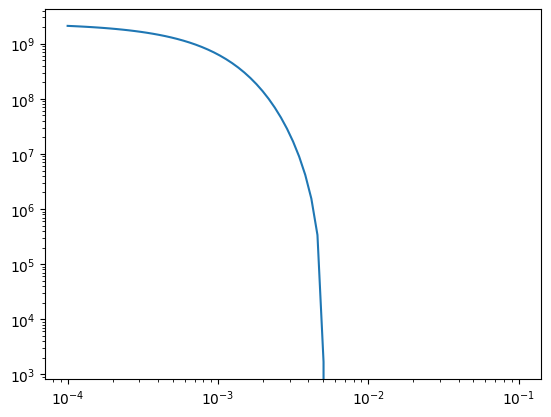

In [4]:
plt.plot(dmrange,rate)
plt.xscale("log")
plt.yscale("log")

In [13]:
dmrange = np.geomspace(1e-4, 1, num=75)
dmrate = lambda x: drde(x, 0.9, 1e-35, tm='Si')

In [14]:
mass_dict = {}
mass_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,200,300,400,500,600,700,800,900,1000]

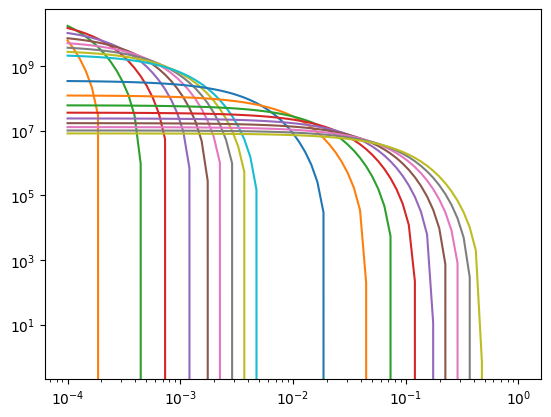

In [15]:
for m in mass_values:
    rate = drde(dmrange, m*1e-3, 1e-35, tm='Si') #100 MeV DM
    plt.plot(dmrange,rate)
    plt.xscale("log")
    plt.yscale("log")

In [16]:
for mass in mass_values:
    # Define the lambda function for dmrate specific to each mass
    dmrate = lambda x, m=mass: drde(x, m*1e-3, 1e-35 , tm='Si') 

    # Add the entry to the main dictionary
    mass_dict[mass] = {
        "dmrate": dmrate,
    }

# Save the dictionary with cloudpickle
with open('mass_dict.pkl', 'wb') as f:
    cloudpickle.dump(mass_dict, f)

In [21]:
x = np.linspace(1e-5, 1, num=1000)

In [22]:
with open('mass_dict.pkl', 'rb') as f:
    mass_dict = cloudpickle.load(f)

# Access the dmrate function and samprange for a specific mass, say 50
mass = 50
dmrate_function = mass_dict[mass]["dmrate"]

# Use the dmrate function
result = dmrate_function(x)
print("Result of dmrate function:", result)


Result of dmrate function: [1.63632744e+10 1.73527713e+07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+